# K-means Image Segmentation

Application of K-means clustering to segment objects in images. See [Wikipedia page](https://en.wikipedia.org/wiki/Image_segmentation) on the process of image segmentation; basically we wish to break down the image into meaningful abstract "segments", which will be easier for us to analyze or reason over. Each segment of pixels will be labelled according to that segment's ID.

In [1]:
import matplotlib.pyplot as plt 

import numpy as np

from skimage.io import imread
from sklearn.metrics import pairwise_distances

np.set_printoptions(suppress=True)

np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Load Images

The following loads grey and color versions of the "bird" and "plane" images from [this dataset](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/dataset/images.html).

Text(0.5, 1.0, 'Plane Color')

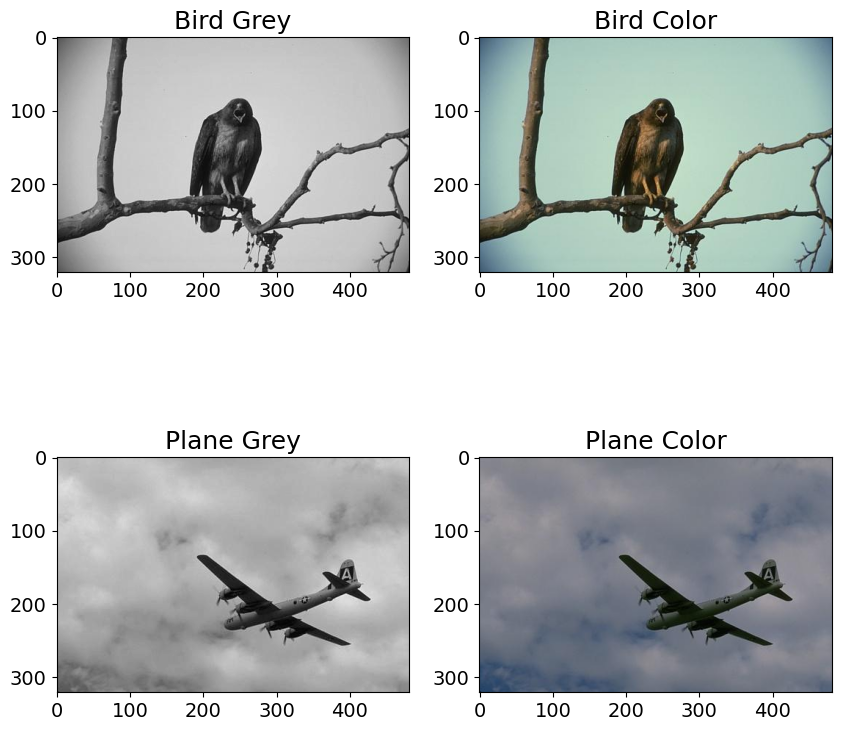

In [2]:
bird_gray = imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/gray/42049.jpg')
bird_color = imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/42049.jpg')
plane_gray = imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/gray/3096.jpg')
plane_color = imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/3096.jpg')
images = [bird_gray, bird_color, plane_gray, plane_color]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(bird_gray, cmap=plt.cm.gray)
ax[0,0].set_title("Bird Grey")
ax[0,1].imshow(bird_color)
ax[0,1].set_title("Bird Color")
ax[1,0].imshow(plane_gray, cmap=plt.cm.gray)
ax[1,0].set_title("Plane Grey")
ax[1,1].imshow(plane_color)
ax[1,1].set_title("Plane Color")

## Feature Generation

As preprocessing, for each pixel, generate a 3 or 5-dimensional feature vector as follows: 

- Append row index, column index, number of channels (1 or 3, grey or RGB) for each pixel into a raw feature vector;
- Normalize each feature entry individually to the interval $[0,1]$, so that all of the feature vectors representing every pixel in an image fit into the 3 or 5-dimensional unit-hypercube;

The 3 or 5-dimensional feature vector will depend on whether you're generating for greyscale or RGB images.

In [3]:
def generate_feature_vector(image):
    # Load image, get its dimensions
    image_np = np.array(image)
    # Return an array of the row and column indices of the image (height and width)
    img_indices = np.indices((image_np.shape[0], image_np.shape[1]))
        
    # Set up data array to store features: row ind, col ind, [num_channels]
    # num_channels = 1 for grayscale and 3 for RGB
    if image_np.ndim == 2:  # Grayscale image
        # Create the features matrix of row and col indices, plus pixel values
        features = np.array([img_indices[0].flatten(), img_indices[1].flatten(), image_np.flatten()])
        # Find ranges of features as max - min
        min_f = np.min(features, axis=1)
        max_f = np.max(features, axis=1)
        ranges = max_f - min_f
        # Each feature normalized to the unit interval [0,1] using max-min normalization: (x - min) / (max - min) 
        # New axis to allow numpy broadcasting
        # np.diag(1/ranges) to perform the division operation in matrix form
        normalized_data = np.diag(1 / ranges).dot(features - min_f[:, np.newaxis])
    elif image_np.ndim == 3: # Color image with RGB values
        # Create the features matrix of row and col indices, plus pixel values
        features = np.array([img_indices[0].flatten(), img_indices[1].flatten(), 
                             image_np[..., 0].flatten(), image_np[..., 1].flatten(), image_np[..., 2].flatten()])
        min_f = np.min(features, axis=1)
        max_f = np.max(features, axis=1)
        ranges = max_f - min_f
        # Each feature normalized to the unit interval [0,1] using max-min normalization: (x - min) / (max - min) 
        # New axis np.newaxis to allow numpy broadcasting
        # np.diag(1/ranges) to perform the division operation in matrix form
        normalized_data = np.diag(1 / ranges).dot(features - min_f[:, np.newaxis])
    else:
        print("Incorrect image dimensions for feature vector")
        
    # Returns feature vector of normalized pixels as shape (height*width, 3 or 5)
    return image_np, normalized_data.T

## K-means Clustering

K-means clustering algorithm for image segmentation below. Note that initial centroids are set randomly in the data space.

In [4]:
### K-means Algorithm ###
def k_means_clustering(X, K, plot=True):
    # Initialize K cluster centroids (K, n) as random values in data space
    centroids = np.random.rand(K, X.shape[1])

    # Convergence when values no longer change, can compare centroids
    converged = False
    # K-means iteration index
    t = 0
    while not converged:
        centroids_prev = centroids

        # Compute pairwise distance to centers
        # dist is of shape (N,K) where dist[i, j] is the Euclidean distance between sample x[i] and centroid mu[j]
        dist = pairwise_distances(X, centroids, metric='euclidean')

        # Step 1: Assign cluster labels to samples
        c = np.argmin(dist, axis=1)

        # Step 2: Move cluster centroids to mean of points assigned to it
        centroids = np.array([np.mean(X[c == k], axis=0) for k in range(K)])

        # Check for convergence
        converged = np.array_equal(centroids, centroids_prev)
        # Update loop iteration
        t += 1
    
    return c, centroids

## Image Segmentation

Apply the K-means clustering algorithm to these normalized feature vectors representing the pixels of the image. Once the cluster labels have been assigned according to the minimum distortion objective of K-means, create "label images" to "paint" the pixels with their cluster assignment. 

Present the original image and the K-means segmentation labels assigned to each pixel side-by-side for easy visual assessment of the segmentation outcome.

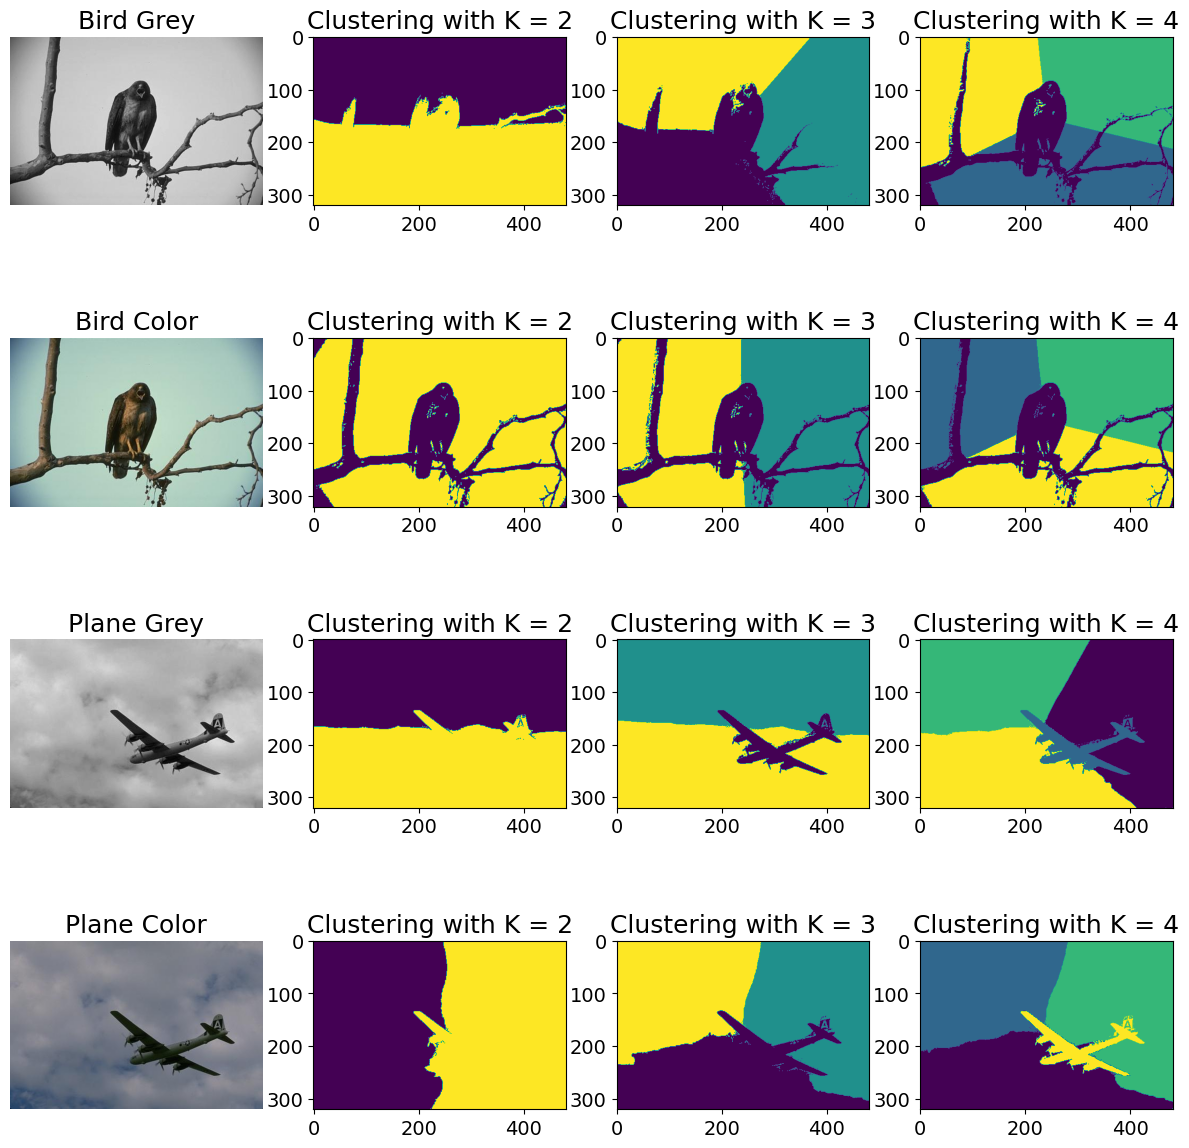

In [5]:
# Create figure to plot all K-means segmentation results for each example image
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
ax[0,0].imshow(bird_gray, cmap=plt.cm.gray)
ax[0,0].set_title("Bird Grey")
ax[0,0].set_axis_off()
ax[1,0].imshow(bird_color)
ax[1,0].set_title("Bird Color")
ax[1,0].set_axis_off()
ax[2,0].imshow(plane_gray, cmap=plt.cm.gray)
ax[2,0].set_title("Plane Grey")
ax[2,0].set_axis_off()
ax[3,0].imshow(plane_color)
ax[3,0].set_title("Plane Color")
ax[3,0].set_axis_off()

# Desired numbers of clusters
K_vals = np.array([2, 3, 4])
# Plot axis index for each image 
i = 0
for img in images:
    ## Generate feature vector on the image
    img_np, feature_vector  = generate_feature_vector(img)
    # Plot axis index for each K-clustered image 
    j = 1
    for K in K_vals:
        ## K-means algorithm
        labels, centroids = k_means_clustering(feature_vector, K)
        # Assigned segment labels reshaped into an image to color-code pixels
        labels_img = labels.reshape(img_np.shape[0], img_np.shape[1])
        ax[i,j].imshow(labels_img)
        ax[i,j].set_title("Clustering with K = {}".format(K))
        j += 1
    # Plot axis index for each image 
    i += 1        

For certain $K$ we are able to clearly differentiate the objects (e.g. plane or bird) from the background. Although depending on the presence of color channels or not, as well as the pixel locations, we observe varying successful segementation results. These features are less affected in image settings with a more uniform, simpler background, such as that of the bird image.